In [28]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
import numpy as np
from sklearn.utils import resample


# Loading the data

In [19]:
#!gsutil -m cp -r gs://ff2s/preproc_data/preproc_photo/ ../preproc_data
#!gsutil -m cp -r gs://ff2s/preproc_data/preproc_sketch/ ../preproc_data

In [29]:
def load_images(path):
    
    raw_name_list=os.listdir(path)
    
    #clean the name list and sort it
    clean_name_list = list()
    for x in raw_name_list:
        if ".jpg" in x:
            clean_name_list.append(x)
    clean_name_list.sort()
    
	# enumerate filenames in directory
    
    data_list = [np.asarray(plt.imread(os.path.join(path,filename))) for filename in clean_name_list]
    
    return np.asarray(data_list)

## Loading the photos as np.array

In [21]:
!ls

AtoB_generated_plot_000100.png README.md
AtoB_generated_plot_000200.png model_dani copy.ipynb
BtoA_generated_plot_000100.png notebooks
BtoA_generated_plot_000200.png preproc_data
FF2S                           requirements.txt
FF2S.egg-info                  setup.py
Makefile


In [30]:
photo_path = os.path.join(os.getcwd(),"preproc_data","preproc_photo/")
photos = load_images(photo_path)

In [31]:
photos.shape

(2006, 256, 256, 3)

## Loading the sketches as np.array

In [32]:
sketch_path = os.path.join(os.getcwd(),"preproc_data","preproc_sketch/")
sketches = load_images(sketch_path)

In [33]:
sketches.shape

(2006, 256, 256, 3)

## Random sample of our data

In [34]:
#To get a subset of all images, for faster training during demonstration
photos_sample = resample(photos,
                         replace=False,
                         n_samples=100,
                         random_state=42) 

#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management. 
sketches_sample = resample(sketches, 
                           replace=False,     
                           n_samples=100,    
                           random_state=42)

## Plotting source images

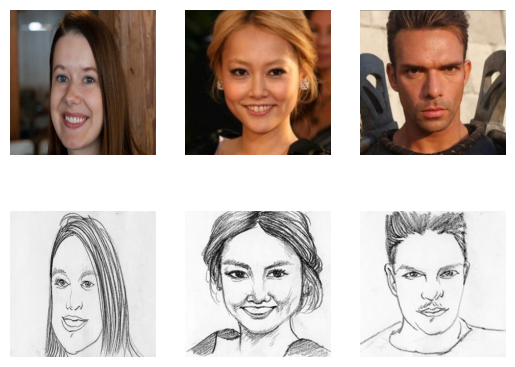

In [35]:
# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(photos_sample[i].astype('uint8'))
 
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(sketches_sample[i].astype('uint8'))
plt.show()

## Image preprocessing

We change input to values between -1 and 1 because the generator uses tanh 
activation in the output layer and tanh ranges between -1 and 1

In [36]:
# load image data
pair = [photos_sample, sketches_sample]

print('Loaded', pair[0].shape, pair[1].shape)

Loaded (100, 256, 256, 3) (100, 256, 256, 3)


In [37]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

pair_preprocessed = preprocess_data(pair)

In [38]:
from FF2S.cycleGAN_model import define_generator, define_discriminator, define_composite_model, train

# define input shape based on the loaded dataset
image_shape = pair_preprocessed[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [39]:
from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, pair_preprocessed, epochs=5)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 [==============================] - 1s 1s/step
Iteration>1, dA[2.157,0.673] dB[0.921,2.235] g[18.224,21.028]
1/1 [==============================] - 1s 831ms/step
Iteration>2, dA[3.788,1.665] dB[3.109,6.200] g[22.124,22.828]
1/1 [==============================] - 1s 816ms/step
Iteration>3, dA[7.200,4.907] dB[2.334,2.344] g[19.900,26.043]
1/1 [==============================] - 1s 880ms/step
Iteration>4, dA[6.853,5.288] dB[2.062,3.057] g[19.805,20.293]
1/1 [==============================] - 1s 832ms/step
Iteration>5, dA[3.211,4.375] dB[1.345,1.314] g[16.607,18.410]
1/1 [==============================] - 1s 970ms/step
Iteration>6, dA[1.949,1.737] dB[1.040,1.435] g[19.205,19.319]
1/1 [==============================] - 1s 860ms/step
Iteration>7, dA[1.132,0.812] dB[0.917,1.395] g[16.629,16.271]
1/1 [==============================] - 1s 850ms/step
Iteration>8, dA[0.888,1.187] dB[0.440,0.935] g[14.536,16.057]
1/1 [==============================] - 1s 879ms/step
Iteration>9, dA[1.040,0.979] d

In [40]:
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = np.vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

In [10]:
# load dataset
photos_sample_2 = resample(photos, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

sketches_sample_2 = resample(sketches, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

A_data = (photos_sample_2 - 127.5) / 127.5
B_data = (sketches_sample_2 - 127.5) / 127.5

NameError: name 'photos' is not defined

In [ ]:
# plot A->B->A (Monet to photo to Monet)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B (Photo to Monet to Photo)
B_real = select_sample(B_data, 1)
A_generated  = g_model_BtoA.predict(B_real)
B_reconstructed = g_model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)